In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import kagglehub

2025-09-03 07:01:08.025409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756882868.399986      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756882868.498563      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path = kagglehub.dataset_download("kmader/food41")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/food41


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [5]:
train_ds2 = image_dataset_from_directory(
    f"{path}/images",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds2 = image_dataset_from_directory(
    f"{path}/images",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 101000 files belonging to 101 classes.
Using 80800 files for training.


I0000 00:00:1756883036.980786      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756883036.981602      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 101000 files belonging to 101 classes.
Using 20200 files for validation.


In [7]:
class_names = train_ds2.class_names
num_classes = len(class_names)
print(f"총 {num_classes}개의 클래스가 준비되었습니다.")
print(class_names)

총 101개의 클래스가 준비되었습니다.
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese',

In [8]:
base_model = EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [10]:
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

In [13]:
history = model.fit(
    train_ds2,
    validation_data=val_ds2,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


I0000 00:00:1756883091.620170     106 service.cc:148] XLA service 0x7a516c1114e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756883091.621594     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756883091.621620     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756883093.643845     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/2525 ━━━━━━━━━━━━━━━━━━━━ 1:52 45ms/step - accuracy: 0.0000e+00 - loss: 4.7494   

I0000 00:00:1756883104.069886     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 339s 123ms/step - accuracy: 0.4382 - loss: 2.4227 - val_accuracy: 0.6472 - val_loss: 1.3782
Epoch 2/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 105s 42ms/step - accuracy: 0.6209 - loss: 1.4558 - val_accuracy: 0.6722 - val_loss: 1.2767
Epoch 3/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 105s 42ms/step - accuracy: 0.6436 - loss: 1.3618 - val_accuracy: 0.6769 - val_loss: 1.2451
Epoch 4/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 106s 42ms/step - accuracy: 0.6507 - loss: 1.3141 - val_accuracy: 0.6823 - val_loss: 1.2278
Epoch 5/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 105s 42ms/step - accuracy: 0.6583 - loss: 1.2896 - val_accuracy: 0.6826 - val_loss: 1.2207
Epoch 6/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 105s 42ms/step - accuracy: 0.6583 - loss: 1.2840 - val_accuracy: 0.6864 - val_loss: 1.2088
Epoch 7/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 105s 42ms/step - accuracy: 0.6645 - loss: 1.2665 - val_accuracy: 0.6858 - val_loss: 1.2087
Epoch 8/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 105s 42ms/step - accuracy: 0.6671 - l

In [14]:
base_model.trainable = True


fine_tune_at = -40
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=10,
        min_lr=0.000001
    )
]

In [15]:
history_fine_tune = model.fit(
    train_ds2,
    validation_data=val_ds2,
    epochs=100,
    callbacks=callbacks2
)

Epoch 1/100


E0000 00:00:1756885230.112474     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756885230.253384     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 173s 55ms/step - accuracy: 0.4451 - loss: 2.3505 - val_accuracy: 0.6565 - val_loss: 1.3573 - learning_rate: 1.0000e-05
Epoch 2/100
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 127s 50ms/step - accuracy: 0.5985 - loss: 1.5366 - val_accuracy: 0.6852 - val_loss: 1.2274 - learning_rate: 1.0000e-05
Epoch 3/100
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 126s 50ms/step - accuracy: 0.6387 - loss: 1.3513 - val_accuracy: 0.6990 - val_loss: 1.1693 - learning_rate: 1.0000e-05
Epoch 4/100
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 126s 50ms/step - accuracy: 0.6628 - loss: 1.2518 - val_accuracy: 0.7073 - val_loss: 1.1317 - learning_rate: 1.0000e-05
Epoch 5/100
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 126s 50ms/step - accuracy: 0.6788 - loss: 1.1922 - val_accuracy: 0.7156 - val_loss: 1.1047 - learning_rate: 1.0000e-05
Epoch 6/100
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 129s 51ms/step - accuracy: 0.6926 - loss: 1.1413 - val_accuracy: 0.7206 - val_loss: 1.0844 - learning_rate: 1.0000e-05
Epoch 7/100
2525/2525 ━━━━━━━━━━━━━━━━━━

In [16]:
val_loss, val_acc=model.evaluate(val_ds2)
print(f"테스트 데이터셋의 손실(Loss): {val_loss:.4f}")
print(f"테스트 데이터셋의 정확도(Accuracy): {val_acc:.4f}")

632/632 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.7749 - loss: 0.9111
테스트 데이터셋의 손실(Loss): 0.9133
테스트 데이터셋의 정확도(Accuracy): 0.7723


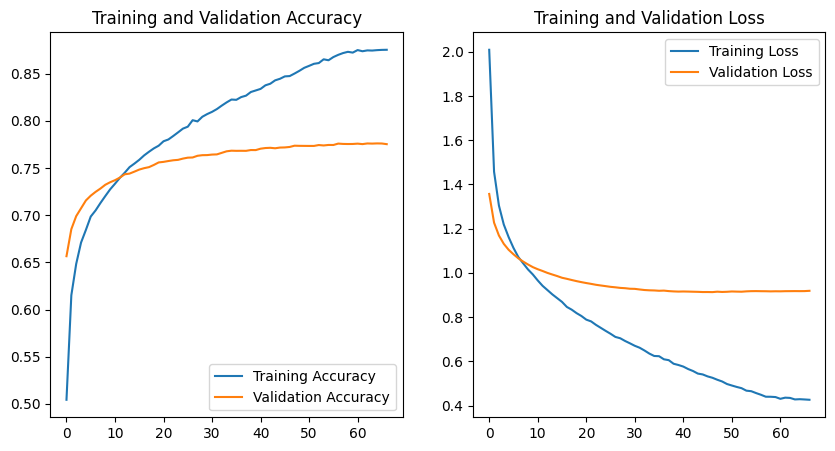

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_fine_tune.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_fine_tune.history['loss'], label='Training Loss')
plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('efficientnet1.png')
plt.show()

In [20]:
model.save('model_efB0_saved_model.keras')